In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Prepare data

In [27]:
df_spotify = pd.read_csv('data/spotify52kData.csv')
df_ratings = pd.read_csv('data/starRatings.csv',header=None)
df_ratings.columns = df_spotify['track_name'].iloc[:5000] # manually specifying the index to be 5000 song names
random_seed = 14276662

In [28]:
# Checking for missing values and the data types of each column
missing_values = df_spotify.isnull().sum()
data_types = df_spotify.dtypes
# Overview of the dataset statistics
dataset_statistics = df_spotify.describe(include='all')

missing_values, data_types, dataset_statistics # data set overall is robust

(songNumber          0
 artists             0
 album_name          0
 track_name          0
 popularity          0
 duration            0
 explicit            0
 danceability        0
 energy              0
 key                 0
 loudness            0
 mode                0
 speechiness         0
 acousticness        0
 instrumentalness    0
 liveness            0
 valence             0
 tempo               0
 time_signature      0
 track_genre         0
 dtype: int64,
 songNumber            int64
 artists              object
 album_name           object
 track_name           object
 popularity            int64
 duration              int64
 explicit               bool
 danceability        float64
 energy              float64
 key                   int64
 loudness            float64
 mode                  int64
 speechiness         float64
 acousticness        float64
 instrumentalness    float64
 liveness            float64
 valence             float64
 tempo               float64
 ti

### Q1: Is there a relationship between song length and popularity of a song? If so, is it positive or negative?

In [19]:
print(df_spotify['popularity'].isnull().sum(), df_spotify['duration'].isnull().sum())
#no null values, no imputation or dropping rows needed

0 0


In [20]:
duration_vals = np.asarray(df_spotify['duration'])
popularity_vals = np.asarray(df_spotify['popularity'])

Text(0.5, 1.0, 'histogram for popularity of a song')

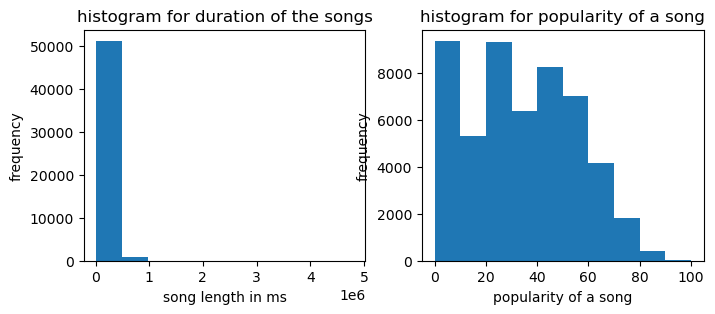

In [21]:
#plot histogram for duration
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(duration_vals)
plt.xlabel("song length in ms")
plt.ylabel("frequency")
plt.title('histogram for duration of the songs')
# Plotting histogram of popularity
plt.subplot(1,2,2)
plt.hist(popularity_vals)
plt.xlabel("popularity of a song")
plt.ylabel("frequency")
plt.title('histogram for popularity of a song')

In [22]:
#test skewness and found the duration data is highly, positively skewed
from scipy.stats import normaltest
print(normaltest(duration_vals),normaltest(popularity_vals))

NormaltestResult(statistic=89338.51687708273, pvalue=0.0) NormaltestResult(statistic=7965.592889275917, pvalue=0.0)


NormaltestResult(statistic=array([248307.41040357]), pvalue=array([0.]))
NormaltestResult(statistic=array([28691.99704698]), pvalue=array([0.]))


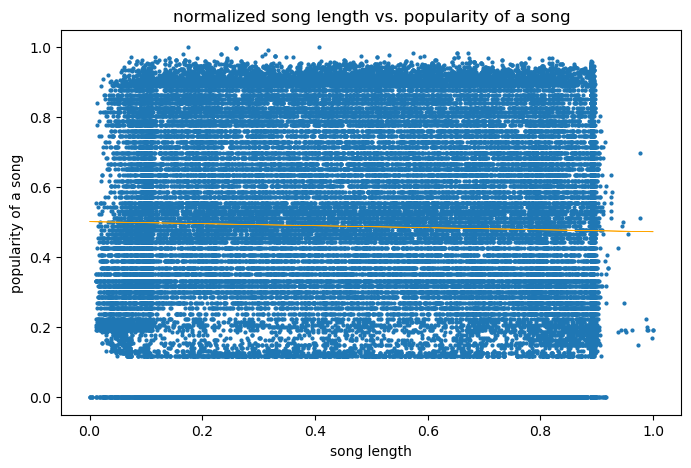

R^2: 0.001
RMSE: 67.01


In [25]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
#normalize the duration data using quantile transformer, then fit linear regression model
qt = QuantileTransformer(n_quantiles=10, random_state=random_seed)
duration_exp = duration_vals.reshape(-1,1)
transformed_duration = qt.fit_transform(duration_exp)
print(normaltest(transformed_duration))
x = transformed_duration.reshape(-1,)
popularity_exp = popularity_vals.reshape(-1,1)
transformed_popularity = qt.fit_transform(popularity_exp)
print(normaltest(transformed_popularity))
y = transformed_popularity.reshape(-1,)
reg1 = LinearRegression()
reg1.fit(transformed_duration,y)
y_hat = float(reg1.coef_[0])*x+ + reg1.intercept_
plt.figure(figsize=(8,5))
plt.plot(x, y, 'o', ms=2)
plt.plot(x, y_hat, color='orange', linewidth=0.5) # orange line for the fox
plt.xlabel("song length")
plt.ylabel("popularity of a song")
plt.title("normalized song length vs. popularity of a song")
plt.show()
r2 = r2_score(y,y_hat)
print('R^2:', r2.round(3))
rmse = np.sqrt(np.mean(np.sum((y-y_hat)**2)))
print('RMSE:', rmse.round(3))

In [26]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

/var/folders/76/3s8ndvb92wb2y403vv_58mkh0000gn/T/ipykernel_36181/1894363853.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=-0.026863326594497035, pvalue=8.969828064924433e-10)

P-value of 8.97e-10<0.05 is in support of the alternative hypothesis that song length and popularity of a song have linear relationship, and they are negatively related. 

### Question 2: Are explicitly rated songs more popular than songs that are not explicit? 

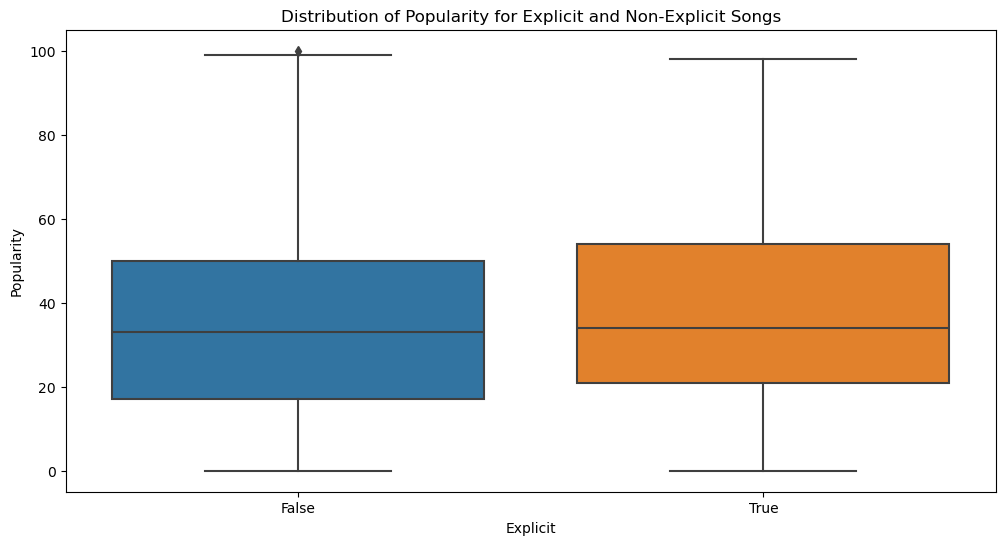

(explicit      0
 popularity    0
 dtype: int64,
 explicit       bool
 popularity    int64
 dtype: object,
 count    5597.000000
 mean       35.813114
 std        22.599548
 min         0.000000
 25%        21.000000
 50%        34.000000
 75%        54.000000
 max        98.000000
 Name: popularity, dtype: float64,
 count    46403.000000
 mean        32.790595
 std         21.615697
 min          0.000000
 25%         17.000000
 50%         33.000000
 75%         50.000000
 max        100.000000
 Name: popularity, dtype: float64)

In [30]:
# Check for missing values and data types in relevant columns
import seaborn as sns
missing_values = df_spotify[['explicit', 'popularity']].isnull().sum()
data_types = df_spotify[['explicit', 'popularity']].dtypes

# Descriptive statistics for both groups
desc_stats_explicit = df_spotify[df_spotify['explicit'] == True]['popularity'].describe()
desc_stats_non_explicit = df_spotify[df_spotify['explicit'] == False]['popularity'].describe()


plt.figure(figsize=(12, 6))
sns.boxplot(x='explicit', y='popularity', data=df_spotify)
plt.title('Distribution of Popularity for Explicit and Non-Explicit Songs')
plt.xlabel('Explicit')
plt.ylabel('Popularity')
plt.show()

missing_values, data_types, desc_stats_explicit, desc_stats_non_explicit

In [32]:
from scipy.stats import levene, ttest_ind
popularity_explicit = df_spotify[df_spotify['explicit'] == True]['popularity']
popularity_non_explicit = df_spotify[df_spotify['explicit'] == False]['popularity']

# Levene's Test for Homogeneity of variances
levene_test_q2 = levene(popularity_explicit, popularity_non_explicit)
print(f"Q2 levene-test result: {levene_test_q2}") 

# Perform Welch's t-test
t_test_result = ttest_ind(popularity_explicit, popularity_non_explicit, equal_var=False)
print(f"\nQ2 t-test result: {t_test_result}")

Q2 levene-test result: LeveneResult(statistic=16.619770656885425, pvalue=4.574027876730567e-05)

Q2 t-test result: TtestResult(statistic=9.495507012337615, pvalue=2.9549869188182215e-21, df=6888.98867996065)


### Question 3: Are songs in major key more popular than songs in minor key?

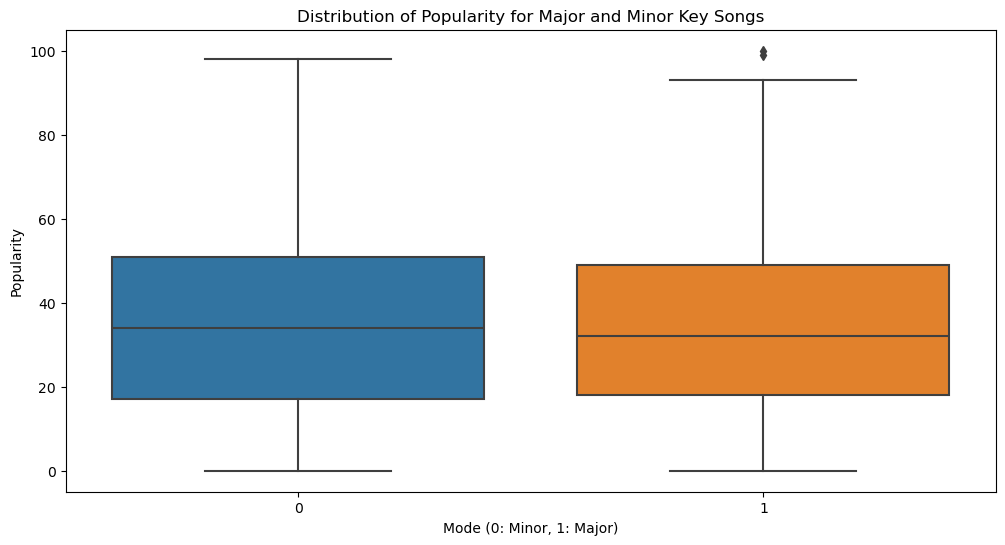

In [33]:
# Visualize the distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='mode', y='popularity', data=df_spotify)
plt.title('Distribution of Popularity for Major and Minor Key Songs')
plt.xlabel('Mode (0: Minor, 1: Major)')
plt.ylabel('Popularity')
plt.show()

In [34]:
# Levene's test
popularity_major = df_spotify[df_spotify['mode'] == 1]['popularity']
popularity_minor = df_spotify[df_spotify['mode'] == 0]['popularity']
levene_test_q3 = levene(popularity_major, popularity_minor)

print(f"Q3 levene-test result: {levene_test_q3}")

# Perform Welch's t-test again after re-importing necessary library
t_test_result = ttest_ind(popularity_major, popularity_minor, equal_var=False, alternative = 'greater')
print(f"\nQ3 t-test result: {t_test_result}")

Q3 levene-test result: LeveneResult(statistic=51.74085604299448, pvalue=6.418259775893402e-13)

Q3 t-test result: TtestResult(statistic=-4.791517372121929, pvalue=0.9999991694543472, df=40576.19476627967)


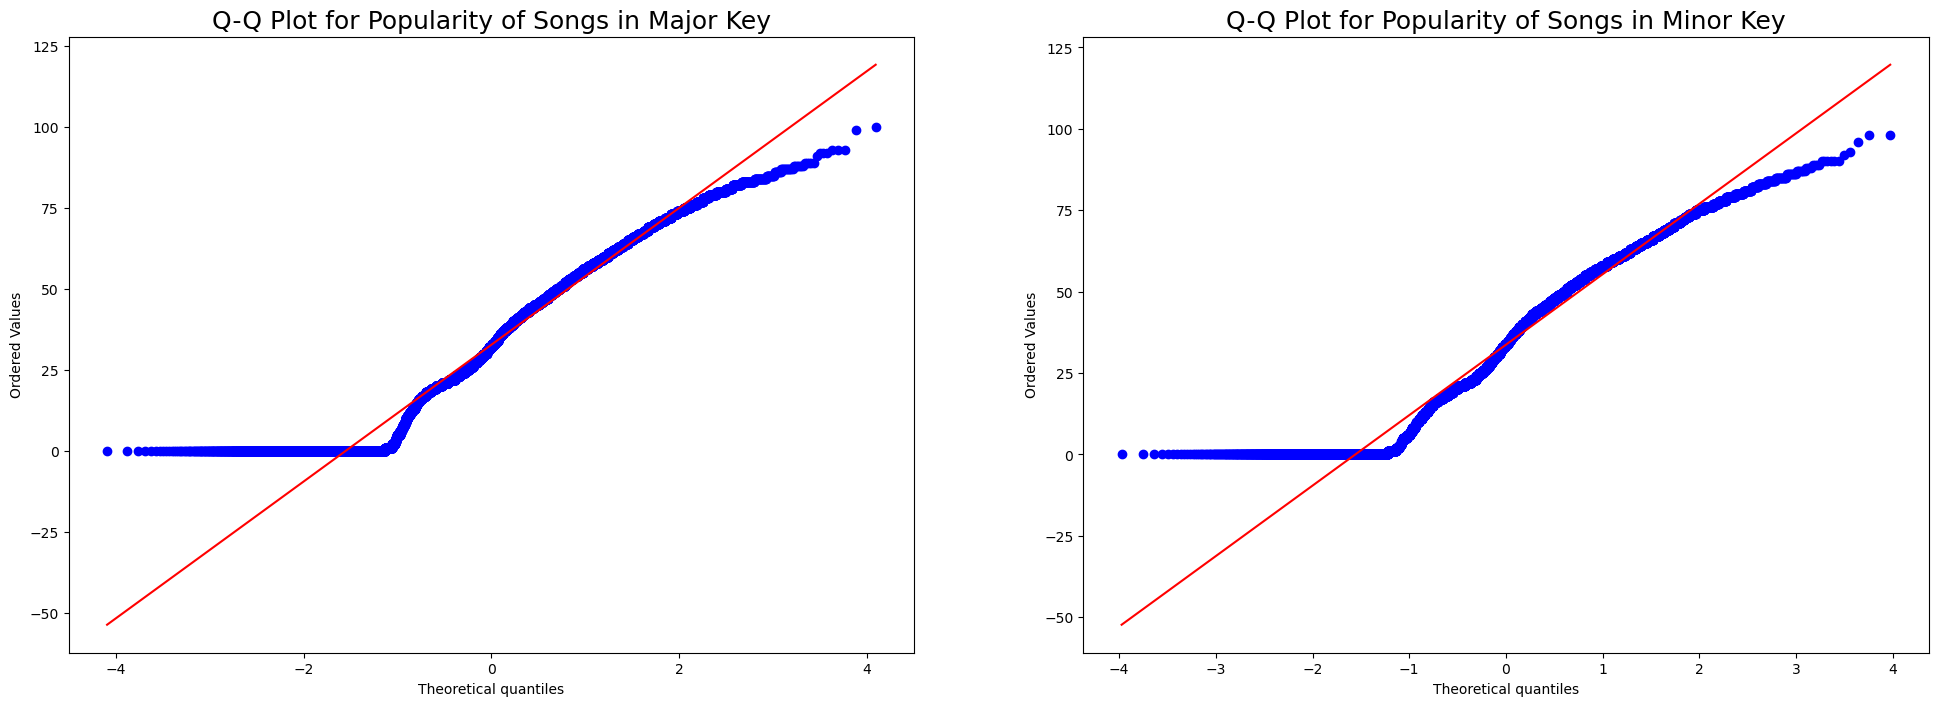

In [36]:
from scipy import stats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8)) 

# Q-Q plot for songs in major key
stats.probplot(popularity_major, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot for Popularity of Songs in Major Key", fontsize = 18)

# Q-Q plot for songs in minor key
stats.probplot(popularity_minor, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot for Popularity of Songs in Minor Key", fontsize = 18)
plt.show()

### Q4: Which of the following 10 song features: duration, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence and tempo predicts popularity best? How good is this model?

In [37]:
column_list = ['duration', 'danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness',
                'valence','tempo']
cols_dict = {}

In [40]:
#we do not transform data to reduce skewness for this question
#because this kind of transformation may reduce R^2 for certain columns
from sklearn.model_selection import cross_val_score, KFold
from scipy import stats
random_seed = 14276662
column = np.asarray(df_spotify['duration'])
skewness1 = stats.skew(column)
logged_col = np.log(column)
skewness2 = stats.skew(logged_col)
col_exp = column.reshape(-1,1)
logged_exp = logged_col.reshape(-1,1)
reg = LinearRegression()
x = col_exp
x_logged = logged_exp
y = popularity_vals
kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2').mean()
scores_for_logged = cross_val_score(reg,x_logged,y,cv=kfold,scoring='r2').mean()
print("skewness reduced from",skewness1,"to",skewness2,"while mean of R^2 dropped from",scores, "to",scores_for_logged)

skewness reduced from 11.56503934705492 to -0.3907430152266713 while mean of R^2 dropped from 0.0027683257445593745 to 0.0001215348581612763


In [43]:
def simple_linear(column_name: str):
    column = np.asarray(df_spotify[column_name])
    col_exp = column.reshape(-1,1)
    reg = LinearRegression()
    x = col_exp
    y = popularity_vals
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2')
    cols_dict[column_name] = scores.mean()

In [44]:
for i in column_list:
    simple_linear(i)

In [45]:
relevance = sorted(cols_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]] for i in relevance]
sorted_list

[['instrumentalness', 0.02078874135752413],
 ['loudness', 0.0034019277308734775],
 ['energy', 0.002915083895579629],
 ['duration', 0.0027683257445593745],
 ['speechiness', 0.002133281425316336],
 ['liveness', 0.001677915314502987],
 ['danceability', 0.0011216160807649867],
 ['valence', 0.000977688415243716],
 ['acousticness', 0.0004707880946256293],
 ['tempo', -0.0002458812831519053]]

In [46]:
table_q4 = pd.DataFrame(sorted_list,columns=['song feature','average COD via 10-fold'])
table_q4

,song feature,average COD via 10-fold
0,instrumentalness,0.020789
1,loudness,0.003402
2,energy,0.002915
3,duration,0.002768
4,speechiness,0.002133
5,liveness,0.001678
6,danceability,0.001122
7,valence,0.000978
8,acousticness,0.000471
9,tempo,-0.000246


### Q5: Building a model that uses *all* of the song features mentioned in question 4, how well can you predict popularity? How much (if at all) is this model improved compared to the model in question 4). How do you account for this? What happens if you regularize your model?

In [48]:
temp_list = []
for i in column_list:
    temp_list.append(np.asarray(df_spotify[i]).reshape(-1,1))
tuple_ten = tuple(temp_list)
x = np.concatenate(tuple_ten, axis=1)
y = popularity_vals
reg = LinearRegression()
kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2')
multi_score = scores.mean()
multi_score

0.04715423740665784

In [49]:
diff = multi_score - sorted_list[0][1]
diff_percent = diff*100/sorted_list[0][1]
print("compared to the best model in question 4, the R^2 increased by",str(diff.round(3))+',','achieving a',str(diff_percent.round(2))+'%',"improvement")

compared to the best model in question 4, the R^2 increased by 0.026, achieving a 126.83% improvement


In [50]:
from sklearn.linear_model import Ridge
alphas=np.arange(0,10,0.5)
best = [0,multi_score]
alpha_dict = {}
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(ridge, x, y, cv=kfold, scoring = 'r2')
    now_score = scores.mean() 
    alpha_dict[alpha] = now_score
    if scores.mean()>best[1]:
        best = [alpha, scores.mean()]
best

[6.5, 0.047154778196946315]

In [51]:
relevance = sorted(alpha_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]-multi_score] for i in relevance]
table_q5 = pd.DataFrame(sorted_list,columns=['alpha','improvement of R^2'])
table_q5

,alpha,improvement of R^2
0,6.5,5.407903e-07
1,6.0,5.393709e-07
2,7.0,5.356040e-07
3,5.5,5.313266e-07
4,7.5,5.238313e-07
5,5.0,5.166380e-07
6,8.0,5.054914e-07
7,4.5,4.952856e-07
8,8.5,4.806034e-07
9,4.0,4.672498e-07


In [52]:
((best[1]-multi_score)/multi_score)*100

0.001146854064906281

In [53]:
best[1]-multi_score

5.407902884738136e-07

In [54]:
from sklearn.linear_model import Lasso
alphas=np.arange(0,10,0.5)
best = [0,multi_score]
alpha_dict = {}
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(lasso, x, y, cv=kfold, scoring = 'r2')
    now_score = scores.mean() 
    alpha_dict[alpha] = now_score
    if scores.mean()>best[1]:
        best = [alpha, scores.mean()]
print(best)

/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+07, tolerance: 2.212e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.li

[0.0, 0.04715423740665786]


In [55]:
relevance = sorted(alpha_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]-multi_score] for i in relevance]
table_q5 = pd.DataFrame(sorted_list,columns=['alpha','improvement of R^2'])
table_q5

,alpha,improvement of R^2
0,0.0,2.081668e-17
1,0.5,-3.044043e-02
2,1.0,-4.065952e-02
3,1.5,-4.078392e-02
4,2.0,-4.095830e-02
5,2.5,-4.118265e-02
6,3.0,-4.145094e-02
7,3.5,-4.175355e-02
8,4.0,-4.207960e-02
9,4.5,-4.244840e-02


### Q6:When considering the 10 song features in the previous question, how many meaningful principal components can you extract? What proportion of the variance do these principal components account for? Using these principal components, how many clusters can you identify? Do these clusters reasonably correspond to the genre labels in column 20 of the data?

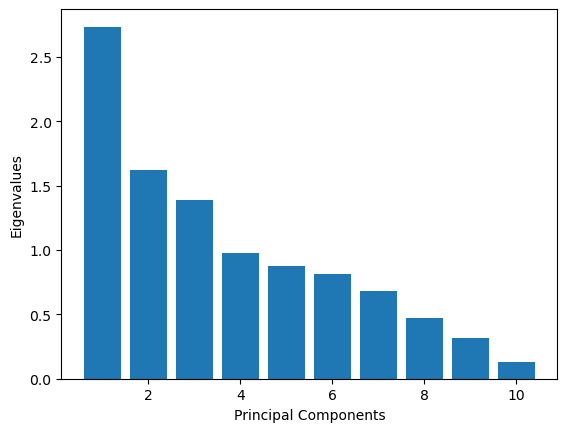

Proportion variance explained by the first 5 PCs: 0.759


In [56]:
from sklearn.decomposition import PCA
# Z-score the data:
zscoredData = stats.zscore(x)

# Initialize PCA object and fit to our data:
pca = PCA().fit(zscoredData)

# Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# Rotated Data - simply the transformed data:
#origDataNewCoordinates = pca.fit_transform(zscoredData)*-1
numPredictors = np.size(x,axis=1)
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()
print('Proportion variance explained by the first 5 PCs:',np.sum(eigVals[:5]/np.sum(eigVals)).round(3))

In [57]:
PCA_dict = {}
for i in range(1,11):
    PCA_dict[i]=np.sum(eigVals[:i]/np.sum(eigVals))
PCA_list = [[i,PCA_dict[i]] for i in PCA_dict]
table_q6 = pd.DataFrame(PCA_list,columns=['top n meaningful principal components','cumulative porportion of variance explained'])
table_q6.style.hide()
    

top n meaningful principal components,cumulative porportion of variance explained
1,0.273388
2,0.435124
3,0.573582
4,0.671541
5,0.759062
6,0.840545
7,0.908372
8,0.955529
9,0.986842
10,1.000000


In [58]:
transformed = PCA(n_components=5).fit_transform(zscoredData)

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
numClusters = 24 # loop over different # of clusters (2 to 25)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums
# Compute kMeans:
for ii in tqdm(range(2, 2+numClusters)): 
    kMeans = KMeans(n_clusters = int(ii)).fit(transformed) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(transformed,cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum

  0%|          | 0/24 [00:00<?, ?it/s]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  4%|▍         | 1/24 [00:34<13:16, 34.62s/it]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  8%|▊         | 2/24 [01:05<11:56, 32.57s/it]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X

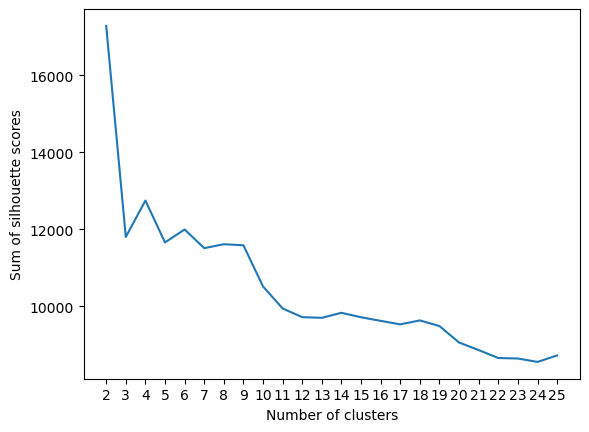

In [60]:
plt.plot(np.arange(2,26,1),Q)
plt.xticks(np.arange(2,26,1))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

In [61]:
kmeans = KMeans(n_clusters = 2, random_state = random_seed).fit(transformed)
labels_kmeans = kmeans.labels_
labels_kmeans

/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [63]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
genres = LE.fit_transform(df_spotify['track_genre'])
np.unique(genres)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [64]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
cluster_zero = np.asarray(labels_kmeans==0).nonzero()[0]
cluster_one = np.asarray(labels_kmeans==1).nonzero()[0]
fit_zero = np.zeros(52)
fit_one = np.zeros(52)
for i in cluster_zero:
    fit_index = genres[i]
    fit_zero[fit_index]+=1
for i in cluster_one:
    fit_index = genres[i]
    fit_one[fit_index]+=1
fit_zero = fit_zero*np.sum(fit_one)/np.sum(fit_zero)
fit_zero

array([2274.10421693,  454.01727299,  241.0711184 ,  321.42815787,
       3608.03107208, 1040.6236611 ,  188.83904275, 1566.96226961,
       1036.60580913,  638.83846377,   28.12496381, 1791.96198012,
       2020.9795426 ,  156.69622696, 1458.48026633, 2157.5865097 ,
       3740.6201872 ,  449.99942102, 1261.60551964,  863.83817427,
         48.21422368,   76.33918749,   28.12496381,  148.66052301,
        626.78490785,  341.51741774, 3105.79957541,   16.07140789,
        172.76763485,  148.66052301,   12.05355592,  401.78519734,
        550.44572035,  454.01727299, 1554.90871369,   36.16066776,
        984.37373347,  313.39245392,  498.2136447 , 1510.71234199,
        843.74891441,  389.73164142,   76.33918749,  273.21393419,
        124.55341117, 3154.01379909,   24.10711184,  180.8033388 ,
         36.16066776,    0.        ,   68.30348355,  136.60696709])

In [65]:
chisquare(fit_zero,fit_one)

Power_divergenceResult(statistic=440200.9978634822, pvalue=0.0)

### Question 7: Can you predict whether a song is in major or minor key from valence using logistic regression or a support vector machine? If so, how good is this prediction? If not, is there a better one?

classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3954
           1       0.62      1.00      0.77      6446

    accuracy                           0.62     10400
   macro avg       0.31      0.50      0.38     10400
weighted avg       0.38      0.62      0.47     10400



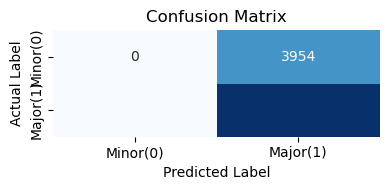

In [67]:
# Setting the random seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
X = df_spotify[['valence']]
y = df_spotify['mode']       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluating
report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'classification report: \n {report}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [68]:
# Check the balance of the classes (major vs. minor keys)
class_balance = df_spotify['mode'].value_counts(normalize=True)
print(f"class balance is: \n{class_balance}")

class balance is: 
mode
1    0.622904
0    0.377096
Name: proportion, dtype: float64


(balanced) classification report: 
               precision    recall  f1-score   support

           0       0.49      0.56      0.52      3871
           1       0.50      0.42      0.46      3973

    accuracy                           0.49      7844
   macro avg       0.49      0.49      0.49      7844
weighted avg       0.49      0.49      0.49      7844



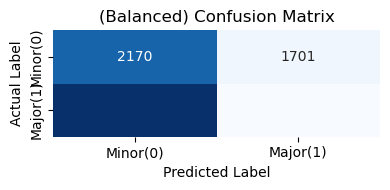

In [74]:
from sklearn.utils import shuffle
major_key_songs = df_spotify[df_spotify['mode'] == 1]
minor_key_songs = df_spotify[df_spotify['mode'] == 0]

# Under-sampling the major key songs
major_key_songs_sampled = major_key_songs.sample(n=len(minor_key_songs), random_state=random_seed)
balanced_df = pd.concat([major_key_songs_sampled, minor_key_songs])
balanced_df = shuffle(balanced_df, random_state=random_seed)
X_balanced = balanced_df[['valence']]
y_balanced = balanced_df['mode']


X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=random_seed)

log_reg_balanced = LogisticRegression()
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)

# Evaluating
accuracy_balanced = np.mean(y_test_balanced == y_pred_balanced)
report_balanced = classification_report(y_test_balanced, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)



print(f'(balanced) classification report: \n {report_balanced}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('(Balanced) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

(balanced) random forest report: 
               precision    recall  f1-score   support

           0       0.52      0.52      0.52      3871
           1       0.54      0.54      0.54      3973

    accuracy                           0.53      7844
   macro avg       0.53      0.53      0.53      7844
weighted avg       0.53      0.53      0.53      7844



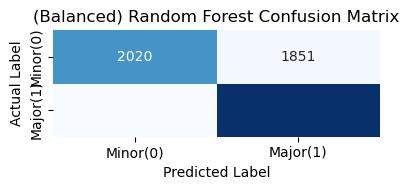

In [75]:
# random forest on balanced dataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
scaler_balanced = StandardScaler()
X_train_balanced_scaled = scaler_balanced.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler_balanced.transform(X_test_balanced)
rf_balanced = RandomForestClassifier(random_state=14276662)
rf_balanced.fit(X_train_balanced_scaled, y_train_balanced)

y_pred_rf_balanced = rf_balanced.predict(X_test_balanced_scaled)

# Evaluating
accuracy_rf_balanced = rf_balanced.score(X_test_balanced_scaled, y_test_balanced)
conf_matrix_rf_balanced = confusion_matrix(y_test_balanced, y_pred_rf_balanced)
class_report_rf_balanced = classification_report(y_test_balanced, y_pred_rf_balanced)

print(f'(balanced) random forest report: \n {class_report_rf_balanced}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix_rf_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('(Balanced) Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Q8:Can you predict genre by using the 10 song features from question 4 directly or the principal components you extracted in question 6 with a neural network? How well does this work?

In [77]:
import math

class Module(object):
    """
    Base class defining the structure and interface for neural network modules 
    with placeholders for forward and backward computations.
    """
    def __init__(self):
        self.gradInput=None # stores gradient
        self.output=None # stores loss
        
    def forward(self, *input):
        """
        Placeholder for forward pass. Defines the computation performed at every call.
        Enforces that subclasses must implement their own version of the forward method
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """
        Placeholder for backward pass. Defines the computation performed at every call.
        Enforces that subclasses must implement their own version of the backward method
        """
        raise NotImplementedError
        
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=52):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1 # gradient of loss
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize, in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features # dimensions
        self.out_features = out_features # dimensions
        np.random.seed(random_seed)
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x): # this is our linear unit
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    """
    Implement the Rectified Linear Unit activation function for introducing non-linearity in the network.
    """
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    

class MLP(Module):
    """
    simple neural network architecture with two linear layers and a ReLU activation function in between.
    """

    def __init__(self, num_features = 10,num_classes=52):
        super(MLP, self).__init__()
        self.fc1 = Linear(num_features, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x) # notice: no relu on the final output
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

In [78]:
def train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels):
    
    n_train, n_val = len(train_data), len(val_data)
    train_loss = np.empty([num_epochs, int(n_train/batch_size)])
    val_loss = np.empty([num_epochs, int(n_val/batch_size)])
    
    for epoch in range(num_epochs):
        
        # Training loop
        for i in range(int(n_train/batch_size)):
            x = train_data[batch_size*i:batch_size*(i+1)]
            y = train_labels[batch_size*i:batch_size*(i+1)]
            y_pred = model.forward(x)
            train_loss[epoch, i] = criterion.forward(y_pred, y)
            grad0 = criterion.backward(y_pred, y)
            grad = model.backward(x, grad0)
            model.gradientStep(learn_rate)  

        # Validation loop
        for j in range(int(n_val/batch_size)):
            x = val_data[batch_size*j:batch_size*(j+1)]
            y = val_labels[batch_size*j:batch_size*(j+1)]
            y_pred = model.forward(x)
            val_loss[epoch, j] = criterion.forward(y_pred, y)
            
        if (epoch+1) % 10 == 0:
            print('Training epoch:', epoch+1)
    
    # Plot output, if desired
    plt.plot(np.mean(train_loss, axis=1))
    plt.plot(np.mean(val_loss, axis=1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','val'])
    plt.show()

In [79]:
class CrossEntropyCriterion(Module):
    """
    This implementation of the cross-entropy loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = -np.sum(target * np.log(np.abs(x) + 1e-8))
        return self.output
            
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]]=x[i,labels[i]]-1
        return self.gradInput

In [80]:
def evaluate_model(model, val_data, val_labels, batch_size, num_samples):
    
    n_val = len(val_data)
    y_pred = np.empty([int(n_val/batch_size), batch_size])
    
    for i in range(int(n_val/batch_size)):
        x = val_data[batch_size*i:batch_size*(i+1)]
        y = val_labels[batch_size*i:batch_size*(i+1)]
        y_pred[i,:] = np.argmax(model.forward(x),axis=1)
    np.random.seed(random_seed)
    rand_index = np.random.randint(len(val_data), size=num_samples)
    model_accuracy = (y_pred.flatten()[rand_index]==val_labels[rand_index]).mean()

    return model_accuracy

In [82]:
temp_list = []
for i in column_list:
    temp_list.append(np.asarray(df_spotify[i]).reshape(-1,1))
tuple_ten = tuple(temp_list)
x = np.concatenate(tuple_ten, axis=1)
x = stats.zscore(x)
LE = LabelEncoder()
genres = LE.fit_transform(df_spotify['track_genre'])

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50
Training epoch: 60
Training epoch: 70
Training epoch: 80
Training epoch: 90
Training epoch: 100


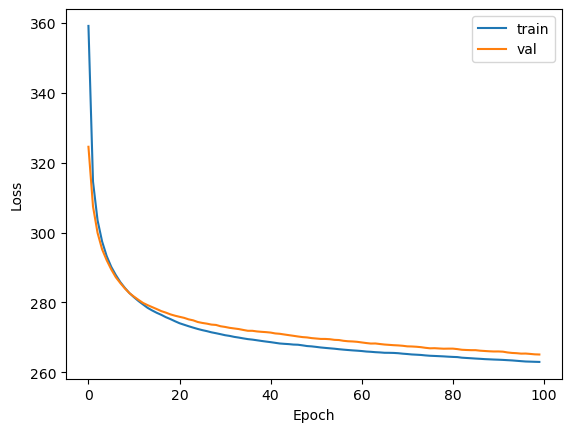

Model accuracy: 0.252


In [84]:
num_epochs = 100
learn_rate = 0.0005
batch_size = 100
num_classes = 52
num_features = 10
X_train, X_test, y_train, y_test = train_test_split(x, genres, test_size=0.2, random_state=random_seed)
model = MLP(num_features, num_classes)
criterion = CrossEntropyCriterion(num_classes)
num_samples = int(1e3)
train_data = X_train
train_labels = y_train
val_data = X_test
val_labels = y_test
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50
Training epoch: 60
Training epoch: 70
Training epoch: 80
Training epoch: 90
Training epoch: 100


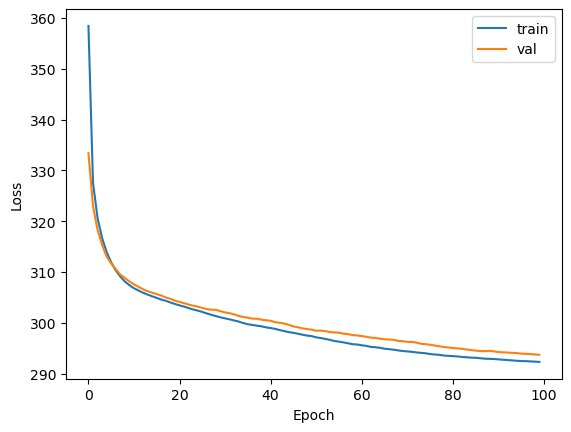

Model accuracy: 0.182


In [85]:
num_epochs = 100
learn_rate = 0.0005
batch_size = 100
num_classes = 52
num_features = 5
X_train, X_test, y_train, y_test = train_test_split(transformed, genres, test_size=0.2, random_state=random_seed)
model = MLP(num_features, num_classes)
criterion = CrossEntropyCriterion(num_classes)
num_samples = int(1e3)
train_data = X_train
train_labels = y_train
val_data = X_test
val_labels = y_test
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

### Question 9: In recommender systems, the popularity based model is an important baseline. We have a two part question in this regard: a) Is there a relationship between popularity and average star rating for the 5k songs we have explicit feedback for? b) Which 10 songs are in the “greatest hits” (out of the 5k songs), on the basis of the popularity based model?

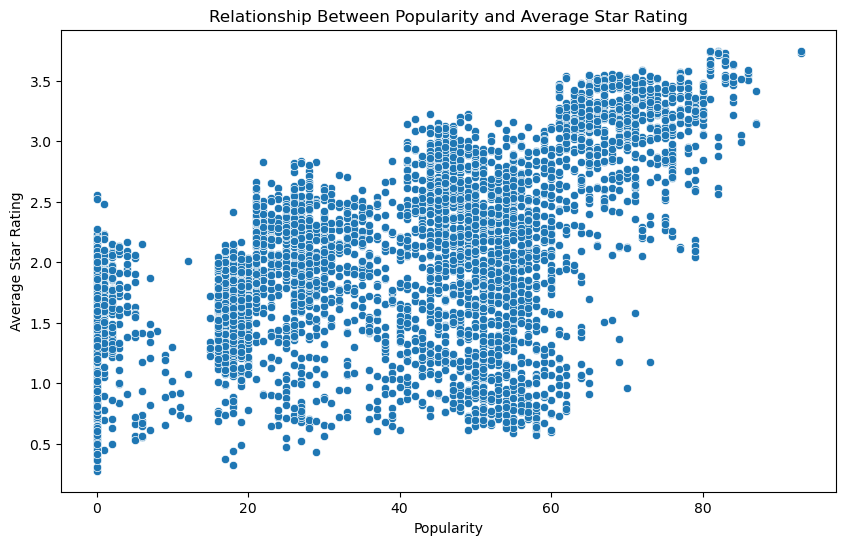

Spearman's rank correlation between popularity and average star rating is 0.543458638456252, with a p-value of 0.0


In [87]:
# Q9a
from scipy.stats import spearmanr
average_ratings = df_ratings.mean(axis=0)
df_spotify['average_rating'] = np.nan
df_spotify.loc[:4999, 'average_rating'] = average_ratings.values

plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='average_rating', data=df_spotify)
plt.title('Relationship Between Popularity and Average Star Rating')
plt.xlabel('Popularity')
plt.ylabel('Average Star Rating')
plt.show()


# Spearman's rank correlation test
spearman_corr, spearman_p_value = spearmanr(df_spotify['popularity'][:5000], df_spotify['average_rating'][:5000])
spearman_corr, spearman_p_value
print(f"Spearman's rank correlation between popularity and average star rating is {spearman_corr}, with a p-value of {spearman_p_value}")

In [89]:
import statsmodels.api as sm
X_ols = df_spotify[['popularity']][:5000]  
y_ols = df_spotify['average_rating'][:5000]
X_ols = sm.add_constant(X_ols)

# OLS model
ols_model = sm.OLS(y_ols, X_ols).fit()
ols_summary = ols_model.summary()
ols_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         average_rating   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     2398.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:32:39   Log-Likelihood:                -4472.1
No. Observations:                5000   AIC:                             8948.
Df Residuals:                    4998   BIC:                             8961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4355      0.014    101.578      0.000       1.408       1.463
popularity     0.0165      0.000     48.967      0.000       0.016       0.017
==============================================================================
Omnibus:                      415.574   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.689
Skew:                          -0.794   Prob(JB):                    4.28e-115
Kurtosis:                       3.086   Cond. No.                         71.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# Q9b
sorted_songs = df_spotify[:5000].sort_values(by='average_rating', ascending=False)
top_10_songs = sorted_songs.head(10)
top_10_songs_details = top_10_songs[['artists', 'track_name', 'album_name', 'average_rating','popularity','track_genre']]
top_10_songs_details

,artists,track_name,album_name,average_rating,popularity,track_genre
3877,The Offspring,"You're Gonna Go Far, Kid","Rise And Fall, Rage And Grace",3.750000,81,alternative
3003,The Neighbourhood,Sweater Weather,I Love You.,3.748950,93,alternative
2260,Red Hot Chili Peppers,Can't Stop,By the Way (Deluxe Edition),3.744554,82,alt-rock
2562,The Offspring,"You're Gonna Go Far, Kid","Rise And Fall, Rage And Grace",3.743202,81,alt-rock
3216,Red Hot Chili Peppers,Californication,Californication (Deluxe Edition),3.741969,82,alternative
2105,Red Hot Chili Peppers,Californication,Californication (Deluxe Edition),3.737475,82,alt-rock
2003,The Neighbourhood,Sweater Weather,I Love You.,3.729651,93,alt-rock
2011,WALK THE MOON,Shut Up and Dance,TALKING IS HARD,3.729124,83,alt-rock
3464,Red Hot Chili Peppers,Can't Stop,By the Way (Deluxe Edition),3.727829,82,alternative
3253,Gorillaz;Tame Impala;Bootie Brown,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),3.727451,82,alternative


In [91]:
# here we explore the repeating entries, with conclusions in our written document

# Finding the rows that are repeated based on both 'track_name' and 'album_name' and 'track_genre'
duplicates = sorted_songs[sorted_songs.duplicated(subset=['track_name', 'album_name','track_genre'], keep=False)]
sorted_duplicates = duplicates.sort_values(by=['track_name', 'album_name','track_genre'])
sorted_duplicates[['songNumber','artists','album_name','track_name','popularity','average_rating']].head()

,songNumber,artists,album_name,track_name,popularity,average_rating
2116,2116,Counting Crows,Alternative Christmas 2022,A Long December,0,1.713858
2168,2168,Counting Crows,Alternative Christmas 2022,A Long December,0,1.681772
3269,3269,Counting Crows,Alternative Christmas 2022,A Long December,0,1.696373
3270,3270,Counting Crows,Alternative Christmas 2022,A Long December,0,1.681729
1001,1001,Criolo,Ainda Há Tempo,Ainda Há Tempo,44,2.557393


### Question 10: You want to create a “personal mixtape” for all 10k users who have explicit feedback for. This mixtape contains individualized recommendations as to the 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [93]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split
### The SVD++ code might take 10 minutes to run ###

reader = Reader(rating_scale=(0, 4))  # Assuming ratings are from 0 to 4
data = Dataset.load_from_df(df_ratings.stack().reset_index(name='rating'), reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state = random_seed)
# model = SVDpp(n_factors=10, n_epochs=3, lr_all=0.01)
# model.fit(trainset)
# predictions = model.test(testset)
# accuracy = rmse(predictions) # result: RMSE=1.0704 

In [94]:
from sklearn.metrics.pairwise import cosine_similarity
ratings_matrix = df_ratings.fillna(-1).values

# user-user cosine similarity
user_similarity = cosine_similarity(ratings_matrix)

# predict ratings
def predict_ratings(user_similarity, ratings):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    return pred
predicted_ratings = predict_ratings(user_similarity, ratings_matrix)

# Generate recommendations
top_n_recommendations = 10
user_recommendations = {}
for user_id in range(predicted_ratings.shape[0]):
    user_unrated_items = np.where(df_ratings.iloc[user_id].isna())[0]
    user_predictions = predicted_ratings[user_id, user_unrated_items]
    top_items_indices = user_predictions.argsort()[-top_n_recommendations:][::-1]
    user_recommendations[user_id] = top_items_indices

In [95]:
# Sample code to calculate Precision and Recall
def calculate_precision_recall(user_recommendations, df_ratings, threshold=3):
    precision_list = []
    recall_list = []

    for user_id, recommended_items in user_recommendations.items():
        # Actual liked items: items rated above the threshold
        actual_liked = set(df_ratings.columns[(df_ratings.iloc[user_id] >= threshold).fillna(False)])

        # Recommended items
        recommended = set(recommended_items)

        # Intersection of liked and recommended items
        relevant_and_recommended = recommended.intersection(actual_liked)

        # Precision and Recall calculations
        precision = len(relevant_and_recommended) / len(recommended) if recommended else 0
        recall = len(relevant_and_recommended) / len(actual_liked) if actual_liked else 0

        precision_list.append(precision)
        recall_list.append(recall)

    # Average Precision and Recall
    average_precision = np.mean(precision_list)
    average_recall = np.mean(recall_list)

    return average_precision, average_recall

average_precision, average_recall = calculate_precision_recall(user_recommendations, df_ratings)
print(f"average recall is: {average_recall}")
print(f"average precision is: {average_precision}")

average recall is: 0.0
average precision is: 0.0


In [96]:
from collections import Counter

all_recommended_songs = [song for recommendations in user_recommendations.values() for song in recommendations]
song_frequency = Counter(all_recommended_songs)
top_10_common_recommendations = [df_spotify.loc[song_id, 'track_name'] for song_id, _ in song_frequency.most_common(10)]
top_10_common_recommendations

["Breezin'",
 'Thank You',
 'Abyssinian Suite, Pt. 4',
 'Mango Cool',
 'Higher Ground - Remastered',
 'Life of Grace',
 'Gracias',
 'A Great Big Sled',
 'Black Summer',
 'sail away']

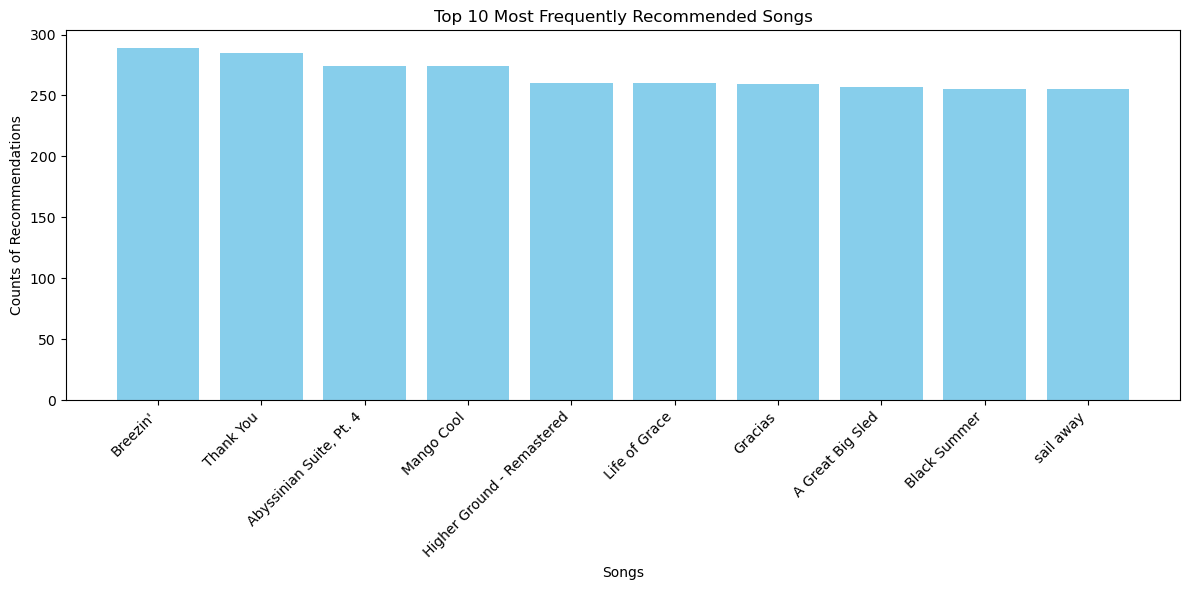

In [97]:
top_10_common_recommendations_indices = song_frequency.most_common(10)
top_10_frequencies = [freq for _, freq in top_10_common_recommendations_indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_10_common_recommendations, top_10_frequencies, color='skyblue')
plt.xlabel('Songs')
plt.ylabel('Counts of Recommendations')
plt.title('Top 10 Most Frequently Recommended Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Extra Credit: Death metal and Children are two genres with great differences. The former is known for harshness, while the latter is known for harmony. We want to investigate whether the beats per measure differ between death metal and children music.

In [99]:
dealth_metal_df = df_spotify[df_spotify['track_genre']=='death-metal']
children_df = df_spotify[df_spotify['track_genre']=='children']

In [100]:
beats_death = np.asarray(dealth_metal_df['time_signature'])
beats_children = np.asarray(children_df['time_signature'])

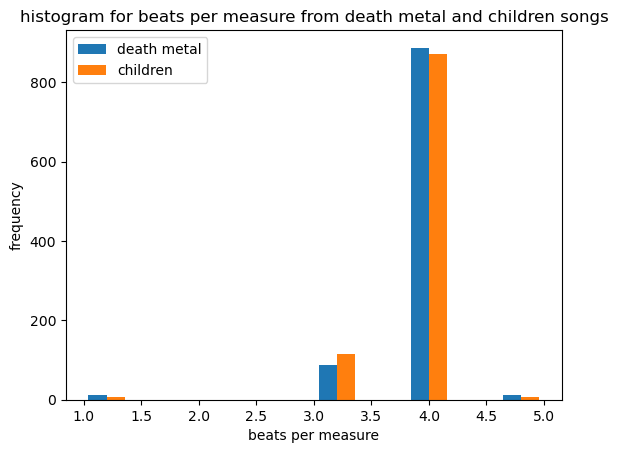

In [101]:
f, ax = plt.subplots()
ax.hist([beats_death,beats_children],label = ['death metal','children'])
ax.set_title("histogram for beats per measure from death metal and children songs")
ax.set_xlabel("beats per measure")
ax.set_ylabel("frequency")
ax.legend()

In [102]:
from scipy.stats import mannwhitneyu
mannwhitneyu(beats_death,beats_children)

MannwhitneyuResult(statistic=511783.0, pvalue=0.10728183535841923)